<a href="https://colab.research.google.com/github/BDouchet/Spotify_dataset/blob/main/popularity_regression/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='16phKfXvRrwGbOJrNKpgbYnBnZG6icXFX'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dataset.zip')

with ZipFile('dataset.zip', 'r') as zip:
   zip.extractall()
   print('Done')

df=pd.read_csv('dataset/Spotify_exo2.csv')

X=df.drop(['genres','popularity'],axis=1).to_numpy()
Y=df['popularity'].to_numpy()

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=10,test_size=0.2)

print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

Done
(2378, 12) (2378,) (595, 12) (595,)


# Create Train Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score

In [ ]:
ss=StandardScaler()

x_train=np.expand_dims(ss.fit_transform(X_train),-1)
x_test=np.expand_dims(ss.fit_transform(X_test),-1)

y_train=(Y_train - np.mean(Y))/np.std(Y)
y_test=(Y_test - np.mean(Y))/np.std(Y)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(2378, 12, 1) (595, 12, 1) (2378,) (595,)


## CNN1

In [ ]:
cnn1=models.Sequential()

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu',input_shape=(12,1)))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu'))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu'))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu'))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64,activation='relu'))
cnn1.add(layers.Dropout(0.2))
cnn1.add(layers.Dense(1,activation='linear'))

cnn1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 10, 64)            256       
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 64)            256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 8, 64)             12352     
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 64)             256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 6, 64)            

In [ ]:
cnn1.compile(optimizer='Adam',metrics=['mae'],loss='mse')
history1=cnn1.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_test,y_test),verbose=0)

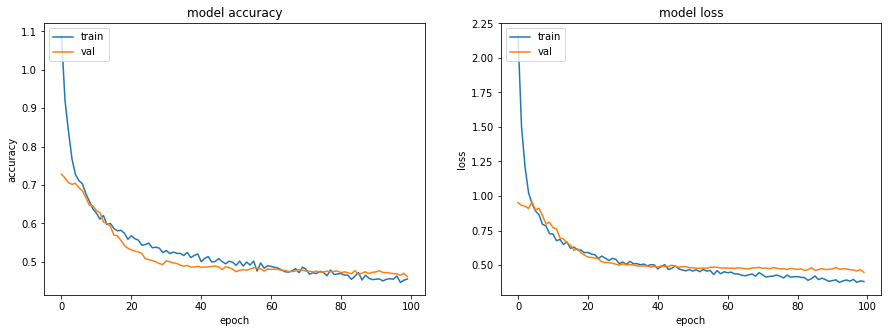

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history1.history['mae'])
ax1.plot(history1.history['val_mae'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history1.history['loss'])
ax2.plot(history1.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_test=cnn1.predict(x_test)*np.std(Y)+np.mean(Y)
yhat_train=cnn1.predict(x_train)*np.std(Y)+np.mean(Y)


print("----- MAE -----")
print(mean_absolute_error(Y_train,yhat_train))
print(mean_absolute_error(Y_test,yhat_test))
print()
print("----- R2 -----")
print(r2_score(Y_train,yhat_train))
print(r2_score(Y_test,yhat_test))

----- MAE -----
6.155494037711033
7.724593072998347

----- R2 -----
0.741388420483491
0.5330714613992638


## CNN2

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 10, 32)       128         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 10, 32)       128         conv1d_69[0][0]                  
__________________________________________________________________________________________________
dropout_74 (Dropout)            (None, 10, 32)       0           batch_normalization_63[0][0]     
____________________________________________________________________________________________

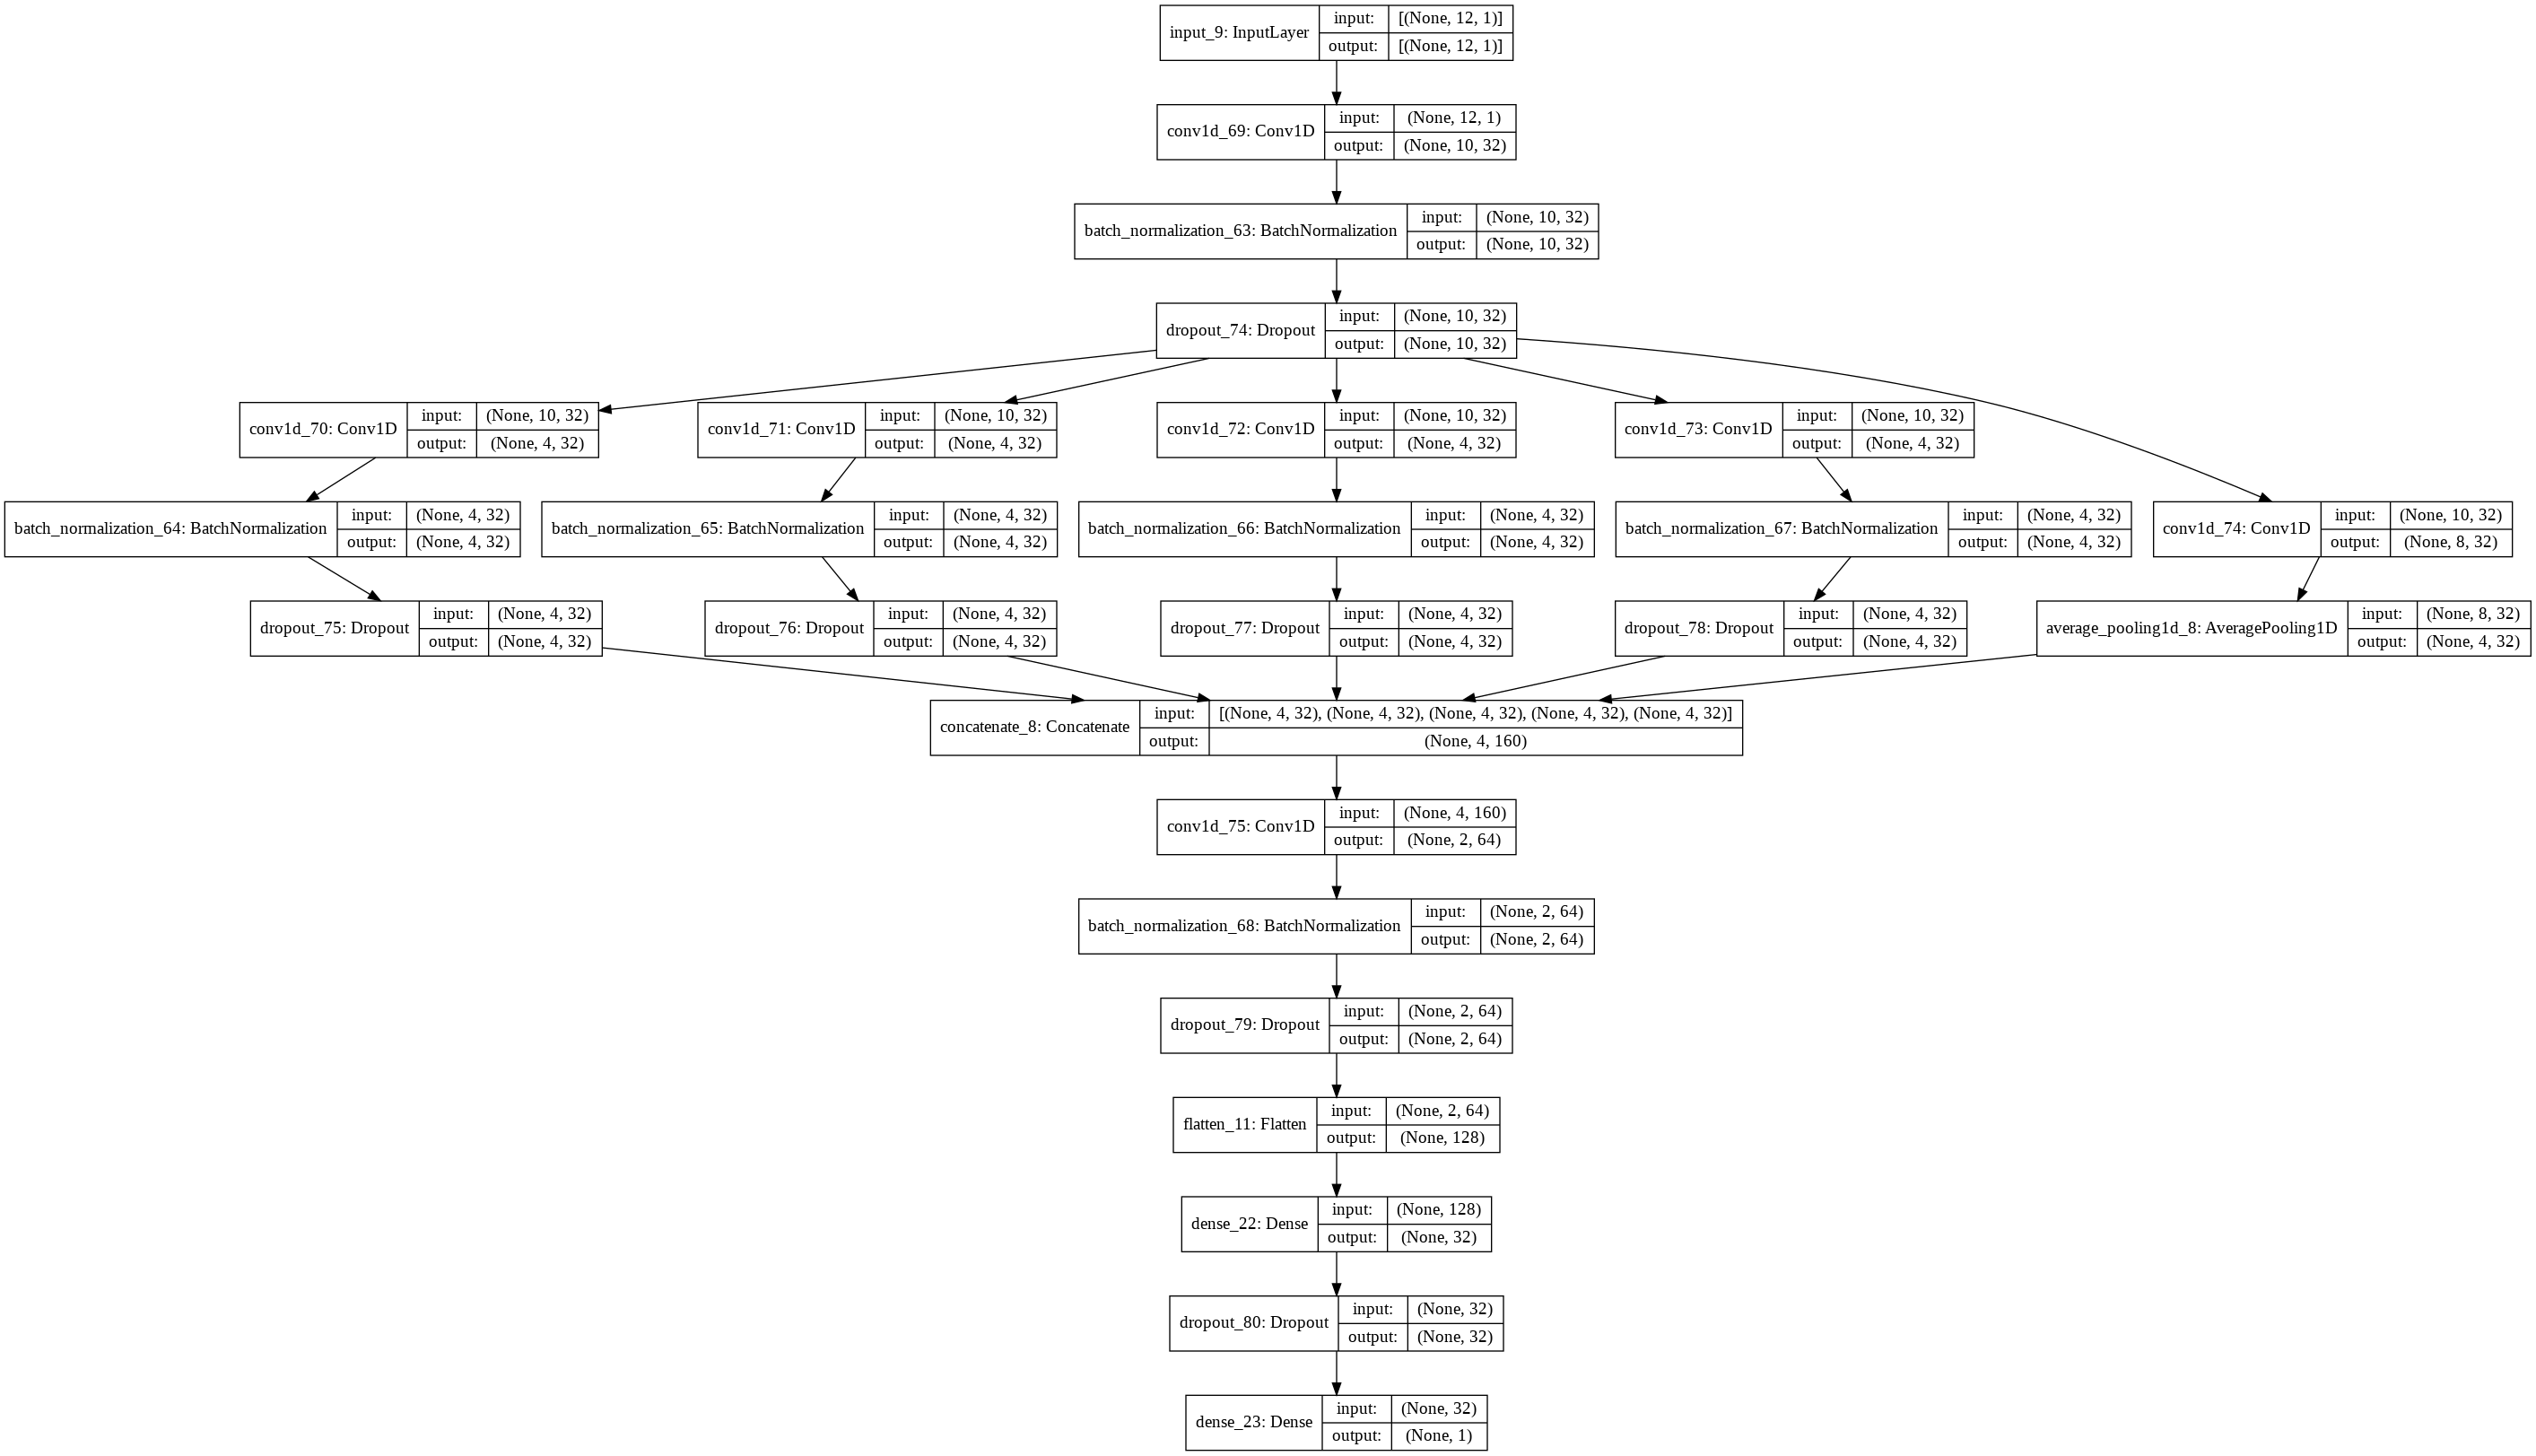

In [ ]:
input=layers.Input(shape=(12,1))

x=layers.Conv1D(32,3,padding='valid',activation='relu')(input)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.2)(x)

b0=layers.Conv1D(32,7,padding='valid',activation='relu',dilation_rate=1)(x)
b0=layers.BatchNormalization()(b0)
b0=layers.Dropout(0.2)(b0)

b1=layers.Conv1D(32,4,padding='valid',activation='relu',dilation_rate=2)(x)
b1=layers.BatchNormalization()(b1)
b1=layers.Dropout(0.2)(b1)

b2=layers.Conv1D(32,3,padding='valid',activation='relu',dilation_rate=3)(x)
b2=layers.BatchNormalization()(b2)
b2=layers.Dropout(0.2)(b2)

b3=layers.Conv1D(32,2,padding='valid',activation='relu',dilation_rate=6)(x)
b3=layers.BatchNormalization()(b3)
b3=layers.Dropout(0.2)(b3)

b4=layers.Conv1D(32,3,padding='valid',activation='relu',dilation_rate=1)(x)
b4=layers.AveragePooling1D()(b4)

x=layers.Concatenate()([b0,b1,b2,b3,b4])

x=layers.Conv1D(64,3,padding='valid',activation='relu')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.2)(x)

x=layers.Flatten()(x)
x=layers.Dense(32,activation='relu')(x)
x=layers.Dropout(0.2)(x)

output=layers.Dense(1,activation='linear')(x)

cnn2=models.Model(input,output)

cnn2.summary()

tf.keras.utils.plot_model(cnn2,show_shapes=True)

In [ ]:
cnn2.compile(optimizer='Adam',metrics=['mae'],loss='mse')
history2=cnn2.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_test,y_test),verbose=0,shuffle=True)

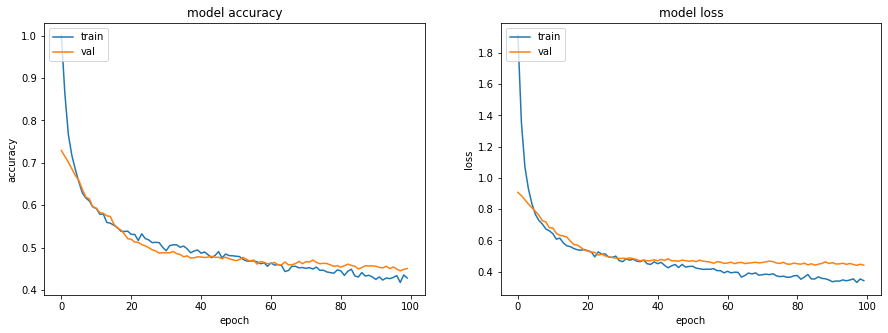

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history2.history['mae'])
ax1.plot(history2.history['val_mae'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_test=cnn2.predict(x_test)*np.std(Y)+np.mean(Y)
yhat_train=cnn2.predict(x_train)*np.std(Y)+np.mean(Y)


print("----- MAE -----")
print(mean_absolute_error(Y_train,yhat_train))
print(mean_absolute_error(Y_test,yhat_test))
print()
print("----- R2 -----")
print(r2_score(Y_train,yhat_train))
print(r2_score(Y_test,yhat_test))

----- MAE -----
5.655948892401127
7.54981244798212

----- R2 -----
0.7824208141248387
0.5389671179194395
